Batch of positive mode files for Justin to have a look at
===


In [5]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
from scipy import stats

base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')

from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
files = []

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/Beer/NegativeMode/Beer_3_Full/csv/'
filename = 'Beer_3_Full1'
files.append((prefix,filename,False))

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/neg/csv/'
filename = 'Urine_37_fullscan1_NEG'
files.append((prefix,filename,False))

prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/Standard_files_Beer_Urine_April2015/Negative_Filtered/csv/'
filename = 'STD_MIX1_60stepped_1E5_Top5'
files.append((prefix,filename,False))
filename = 'STD_MIX2_60stepped_1E5_Top5'
files.append((prefix,filename,False))
filename = 'STD_MIX3_60stepped_1E5_Top5'
files.append((prefix,filename,False))



In [7]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/neg_transformations_camra.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Charge Probabilities
+Cl: 0.250
-2H: 0.125
-H: 0.625

Adduct Probabilities
-CO: 0.074
+CH2O2: 0.074
none: 0.370
+ACN: 0.074
-C2H2: 0.037
-C2H2O2: 0.037
-CH2O2: 0.074
-H2O: 0.074
+NH3: 0.074
-CH4: 0.037
-CO2: 0.074

Isotope Probabilities
C13: 0.154
mono: 0.769
2C13: 0.077

Multiplicity Probabilities
1: 0.909
2: 0.091
Loaded 132 transformations


In [8]:
bl = BetaLike()
clusterings = {}

for f in files:

    filename = f[1]
    prefix = f[0]
    print "Running file " + filename
    csvfile = prefix + filename + '.csv'
    matfile = prefix + filename + '.corr.mat'
    signalfile = prefix + filename + '.peakml.signal'
    # Simon is an idiot...remember to change 'correct = True' or 'correct = False' 
    # coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.7,correct=True)
    coc = CorrCluster(bl,csvfile,corr_file=matfile,signal_file=signalfile,greedy_thresh=0.7,correct=f[2],data_type='correlation')
    clusterings[filename] = coc

Running file Beer_3_Full1
1356.4
Loaded 5668 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/Beer/NegativeMode/Beer_3_Full/csv/Beer_3_Full1.corr.mat
Greedy clustering done, resulting in 947 clusters
Running file Urine_37_fullscan1_NEG
138
Loaded 6662 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/urine/neg/csv/Urine_37_fullscan1_NEG.corr.mat
Greedy clustering done, resulting in 1128 clusters
Running file STD_MIX1_60stepped_1E5_Top5
1385.1300048828
Loaded 1580 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/Standard_files_Beer_Urine_April2015/Negative_Filtered/csv/STD_MIX1_60stepped_1E5_Top5.corr.mat
Greedy clustering done, resulting in 411 clusters
Running file STD_MIX2_60stepped_1E5_Top5
Loaded 1589 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/ms1fundata/Standard_files_Beer_Urine_April2015/Negat

In [9]:
from voter import Voter,PeakGroup
groups = {}
for f in files:
    v = Voter(transformations)
    filename = f[1]
    print "Performing voting on file {}".format(filename)
    file_groups = []
    for cluster in clusterings[filename].clusters:
        file_groups += v.make_groups(cluster.members)
    groups[filename] = file_groups

Performing voting on file Beer_3_Full1
Performing voting on file Urine_37_fullscan1_NEG
Performing voting on file STD_MIX1_60stepped_1E5_Top5
Performing voting on file STD_MIX2_60stepped_1E5_Top5
Performing voting on file STD_MIX3_60stepped_1E5_Top5


In [10]:
from databases import Standards
st = Standards()
all_hits = {}
for f in files:
    filename = f[1]
    all_hits[filename] = st.get_group_hits(groups[filename],use_max_vote = True)

    

In [11]:
# Sort the groups according to votes (top ones first)
global_adduct_counts = {}
global_charge_counts = {}
global_transformation_counts = {}
for f in files:
    filename = f[1]
    outpre = 'standard_output/neg/' + filename

    temp_groups = sorted(groups[filename],key = lambda x:x.vote,reverse=True)
    outfile = outpre + '_by_vote.txt'
    outfile2 = outpre + '_by_vote_MH_not_base.txt'



    with open(outfile,'w') as f:
        with open(outfile2,'w') as f2:
            for i,group in enumerate(temp_groups):
                line = "vote: {}, M: {}\n".format(group.vote,group.M)
                f.write(line)
                head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
                f.write(head_line)
                max_intense = 0.0
                max_intense_transform = None
                for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                    line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                    f.write(line)
                    if peak.intensity > max_intense:
                        max_intense = peak.intensity
                        max_intense_transform = transformation
                f.write('\n')
                
                if not max_intense_transform.name == 'M-H':
                    line = "vote: {}, M: {}\n".format(group.vote,group.M)
                    f2.write(line)
                    head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
                    f2.write(head_line)
                    for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                        line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                        f2.write(line)
                    f2.write('\n')
            
    temp_groups = sorted(groups[filename],key = lambda x:x.M)
    outfile = outpre + '_by_M.txt'
    
    with open(outfile,'w') as f:
        for i,group in enumerate(temp_groups):
            line = "vote: {}, M: {}\n".format(group.vote,group.M)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')

    with open(outpre + '_matched_std.txt','w') as f:
        for mol in all_hits[filename]:
            group = all_hits[filename][mol]
            line = "{} (vote={})\n".format(mol,group.vote)
            f.write(line)
            head_line = '\tPeak m/z,Peak rt,Peak intensity,transformation (transformed mass,vote)\n'
            f.write(head_line)
            for (peak,transformation,transmass) in sorted(group.members,key = lambda x: x[1].vote,reverse=True):
                line = "\t{:.4f},{:.4f},{:.2e},{} ({:.4f},{})\n".format(peak.mass,peak.rt,peak.intensity,transformation,transmass,transformation.vote)
                f.write(line)
            f.write('\n')


    include_singletons = False
    trans_counts = {}
    tot = 0
    for tr in transformations:
        trans_counts[tr] = 0
    for group in groups[filename]:
        if not include_singletons:
            if len(group.members) == 1:
                continue
        for p,t,_ in group.members:
            trans_counts[t] += 1
            tot += 1

    with open(outpre + '_tran_counts.txt','w') as f:
        for tr in sorted(transformations,key = lambda x: x.vote, reverse=True):
            line = "{},{},{:.4f}\n".format(tr,trans_counts[tr],trans_counts[tr]/(1.0*tot))
            f.write(line)

    # output the counts of particular adducts / fragments
    charge_counts = {}
    adduct_counts = {}
    adduct_tot = 0
    charge_tot = 0
    for tr in transformations:
        f = tr.charge_name
        if not f in charge_counts:
            charge_counts[f] = 0
        a = tr.adducts
        if not a in adduct_counts:
            adduct_counts[a] = 0
                
    for group in groups[filename]:
        for p,t,_ in group.members:
            f = t.charge_name
            charge_counts[f] += 1
            charge_tot += 1
            a = t.adducts
            adduct_counts[a] += 1
            adduct_tot += 1
                
    with open(outpre + '_adduct_counts.txt','w') as f:
        for a in adduct_counts:
            line = "{},{},{:.4f}\n".format(a,adduct_counts[a],adduct_counts[a]/(1.0*adduct_tot))
            f.write(line)
    
    with open(outpre + '_charge_counts.txt','w') as f:
        for fr in charge_counts:
            line = "{},{},{:.4f}\n".format(fr,charge_counts[fr],charge_counts[fr]/(1.0*charge_tot))
            f.write(line)
    
    global_adduct_counts[filename] = adduct_counts
    global_charge_counts[filename] = charge_counts
    global_transformation_counts[filename] = trans_counts

Create the table for standards versus transformations

In [12]:
sorted_transforms = sorted(transformations,key = lambda x: x.vote,reverse=True)
intense = {}
for f in files:
    filename = f[1]
    outpre = 'standard_output/neg/' + filename
    outfile = outpre + '_std_table.csv'
    with open(outfile,'w') as of:
        heads = "mol"
        for tr in sorted_transforms:
            heads += "," + tr.name
        of.write(heads+'\n')
        for mol in all_hits[filename]:
            group = all_hits[filename][mol]
            line = "{}".format(mol.name)
            for tr in sorted_transforms:
                found = False
                for p,t,_ in group.members:
                    if t == tr:
                        line += ",{:.2e}".format(p.intensity)
                        found = True
                        break
                if not found:
                    line += ","
            of.write(line + '\n')
            
        

In [13]:
# Note this just does percentages
# Note 2 - for fragments, this is normalised according to things that have fragments
all_charges = []
for fi in global_charge_counts:
    charges = global_charge_counts[fi].keys()
    for fr in charges:
        if not fr in all_charges:
            all_charges.append(fr)

all_files = global_charge_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for fr in global_charge_counts[filename]:
        tot += global_charge_counts[filename][fr]
    totals[filename] = tot

charge_perc = {}
for filename in all_files:
    charge_perc[filename] = []
    for fr in all_charges:
        charge_perc[filename].append(global_charge_counts[filename][fr]/(1.0*totals[filename]))
            
with open('standard_output/neg/global_charges.txt','w') as f:
    st = "Charge carrier"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for fr in all_charges:
        st = fr
        for filename in all_files:
            st += ",{}".format(global_charge_counts[filename][fr]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        

        
# ADDUCTS
all_adducts = []
for fi in global_adduct_counts:
    adds = global_adduct_counts[fi].keys()
    for ad in adds:
        if not ad in all_adducts:
            all_adducts.append(ad)

all_files = global_adduct_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for ad in global_adduct_counts[filename]:
        tot += global_adduct_counts[filename][ad]
    totals[filename] = tot
    
adduct_perc = {}
for filename in all_files:
    adduct_perc[filename] = []
    for ad in all_adducts:
        adduct_perc[filename].append(global_adduct_counts[filename][ad]/(1.0*totals[filename]))    

with open('standard_output/neg/global_adducts.txt','w') as f:
    st = "Adduct"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for ad in all_adducts:
        st = ad
        for filename in all_files:
            st += ",{}".format(global_adduct_counts[filename][ad]/(1.0*totals[filename]))
        f.write(st+'\n')
        
        
        
# TRANSFORMATIONS
all_trans = []
for fi in global_transformation_counts:
    adds = global_transformation_counts[fi].keys()
    for tr in adds:
        if not tr in all_trans:
            all_trans.append(tr)

all_files = global_transformation_counts.keys()
totals = {}
for filename in all_files:
    tot = 0
    for tr in global_transformation_counts[filename]:
        tot += global_transformation_counts[filename][tr]
    totals[filename] = tot
            
        
trans_perc = {}
all_trans = global_transformation_counts[fi].keys()
all_trans = sorted(all_trans,key=lambda x: x.vote,reverse=True)
for filename in all_files:
    trans_perc[filename] = []
    for tr in all_trans:
        trans_perc[filename].append(global_transformation_counts[filename][tr]/(1.0*totals[filename]))


with open('standard_output/neg/global_transformations.txt','w') as f:
    st = "Transformation"
    for filename in all_files:
        st += ',{}'.format(filename)
    f.write(st+'\n')
    for tr in sorted(all_trans,key = lambda x: x.vote,reverse=True):
        st = tr.name
        for filename in all_files:
            st += ",{}".format(global_transformation_counts[filename][tr]/(1.0*totals[filename]))
        f.write(st+'\n')

[0, 1, 2]
0 STD_MIX2_60stepped_1E5_Top5
1 STD_MIX3_60stepped_1E5_Top5
2 STD_MIX1_60stepped_1E5_Top5
3 Beer_3_Full1
4 Urine_37_fullscan1_NEG


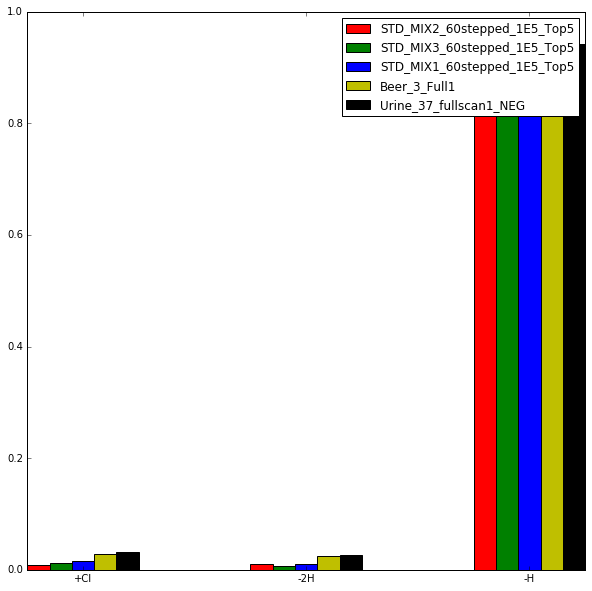

In [14]:
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_charges)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],charge_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_charges)
plt.savefig('standard_output/neg/charge_bars.png',dpi=200)





[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
0 STD_MIX2_60stepped_1E5_Top5
1 STD_MIX3_60stepped_1E5_Top5
2 STD_MIX1_60stepped_1E5_Top5
3 Beer_3_Full1
4 Urine_37_fullscan1_NEG
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0 STD_MIX2_60stepped_1E5_Top5
1 STD_MIX3_60stepped_1E5_Top5
2 STD_MIX1_60stepped_1E5_Top5
3 Beer_3_Full1
4 Urine_37_fullscan1_NEG


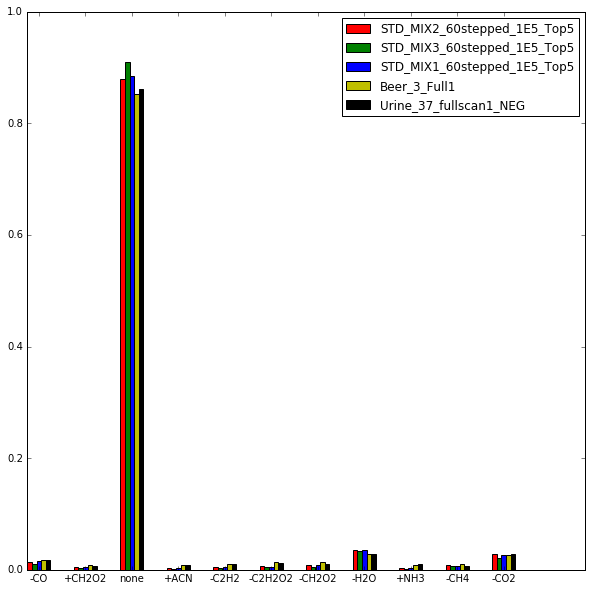

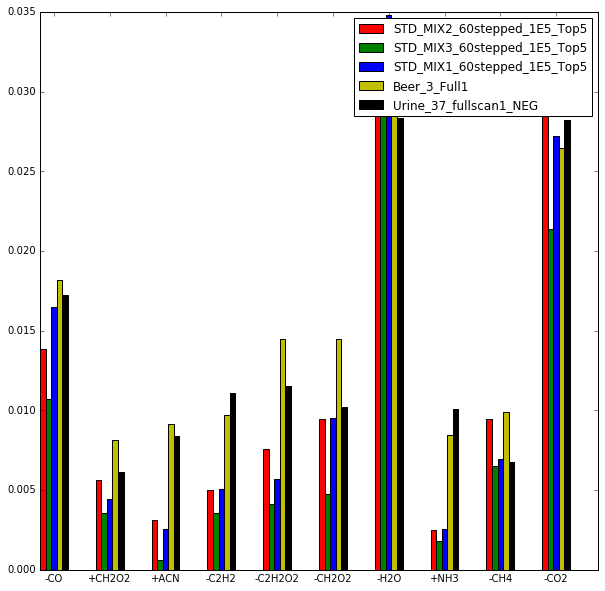

In [15]:
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_adducts)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],adduct_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_adducts)

import copy
# Repeat without M+H
adduct_perc2 = copy.deepcopy(adduct_perc)
all_adducts2 = copy.deepcopy(all_adducts)
mhi = all_adducts2.index("none")
del all_adducts2[mhi]
for fi in adduct_perc2:
    del adduct_perc2[fi][mhi]
    
plt.figure(figsize=(10,10))
plt.size((10,10))
N = len(all_adducts2)
posn = range(N)
print posn
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    print i,filename
    rects.append(plt.bar([p+width*i for p in posn],adduct_perc2[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_adducts2)
plt.savefig('standard_output/neg/add_bars.png',dpi=200)

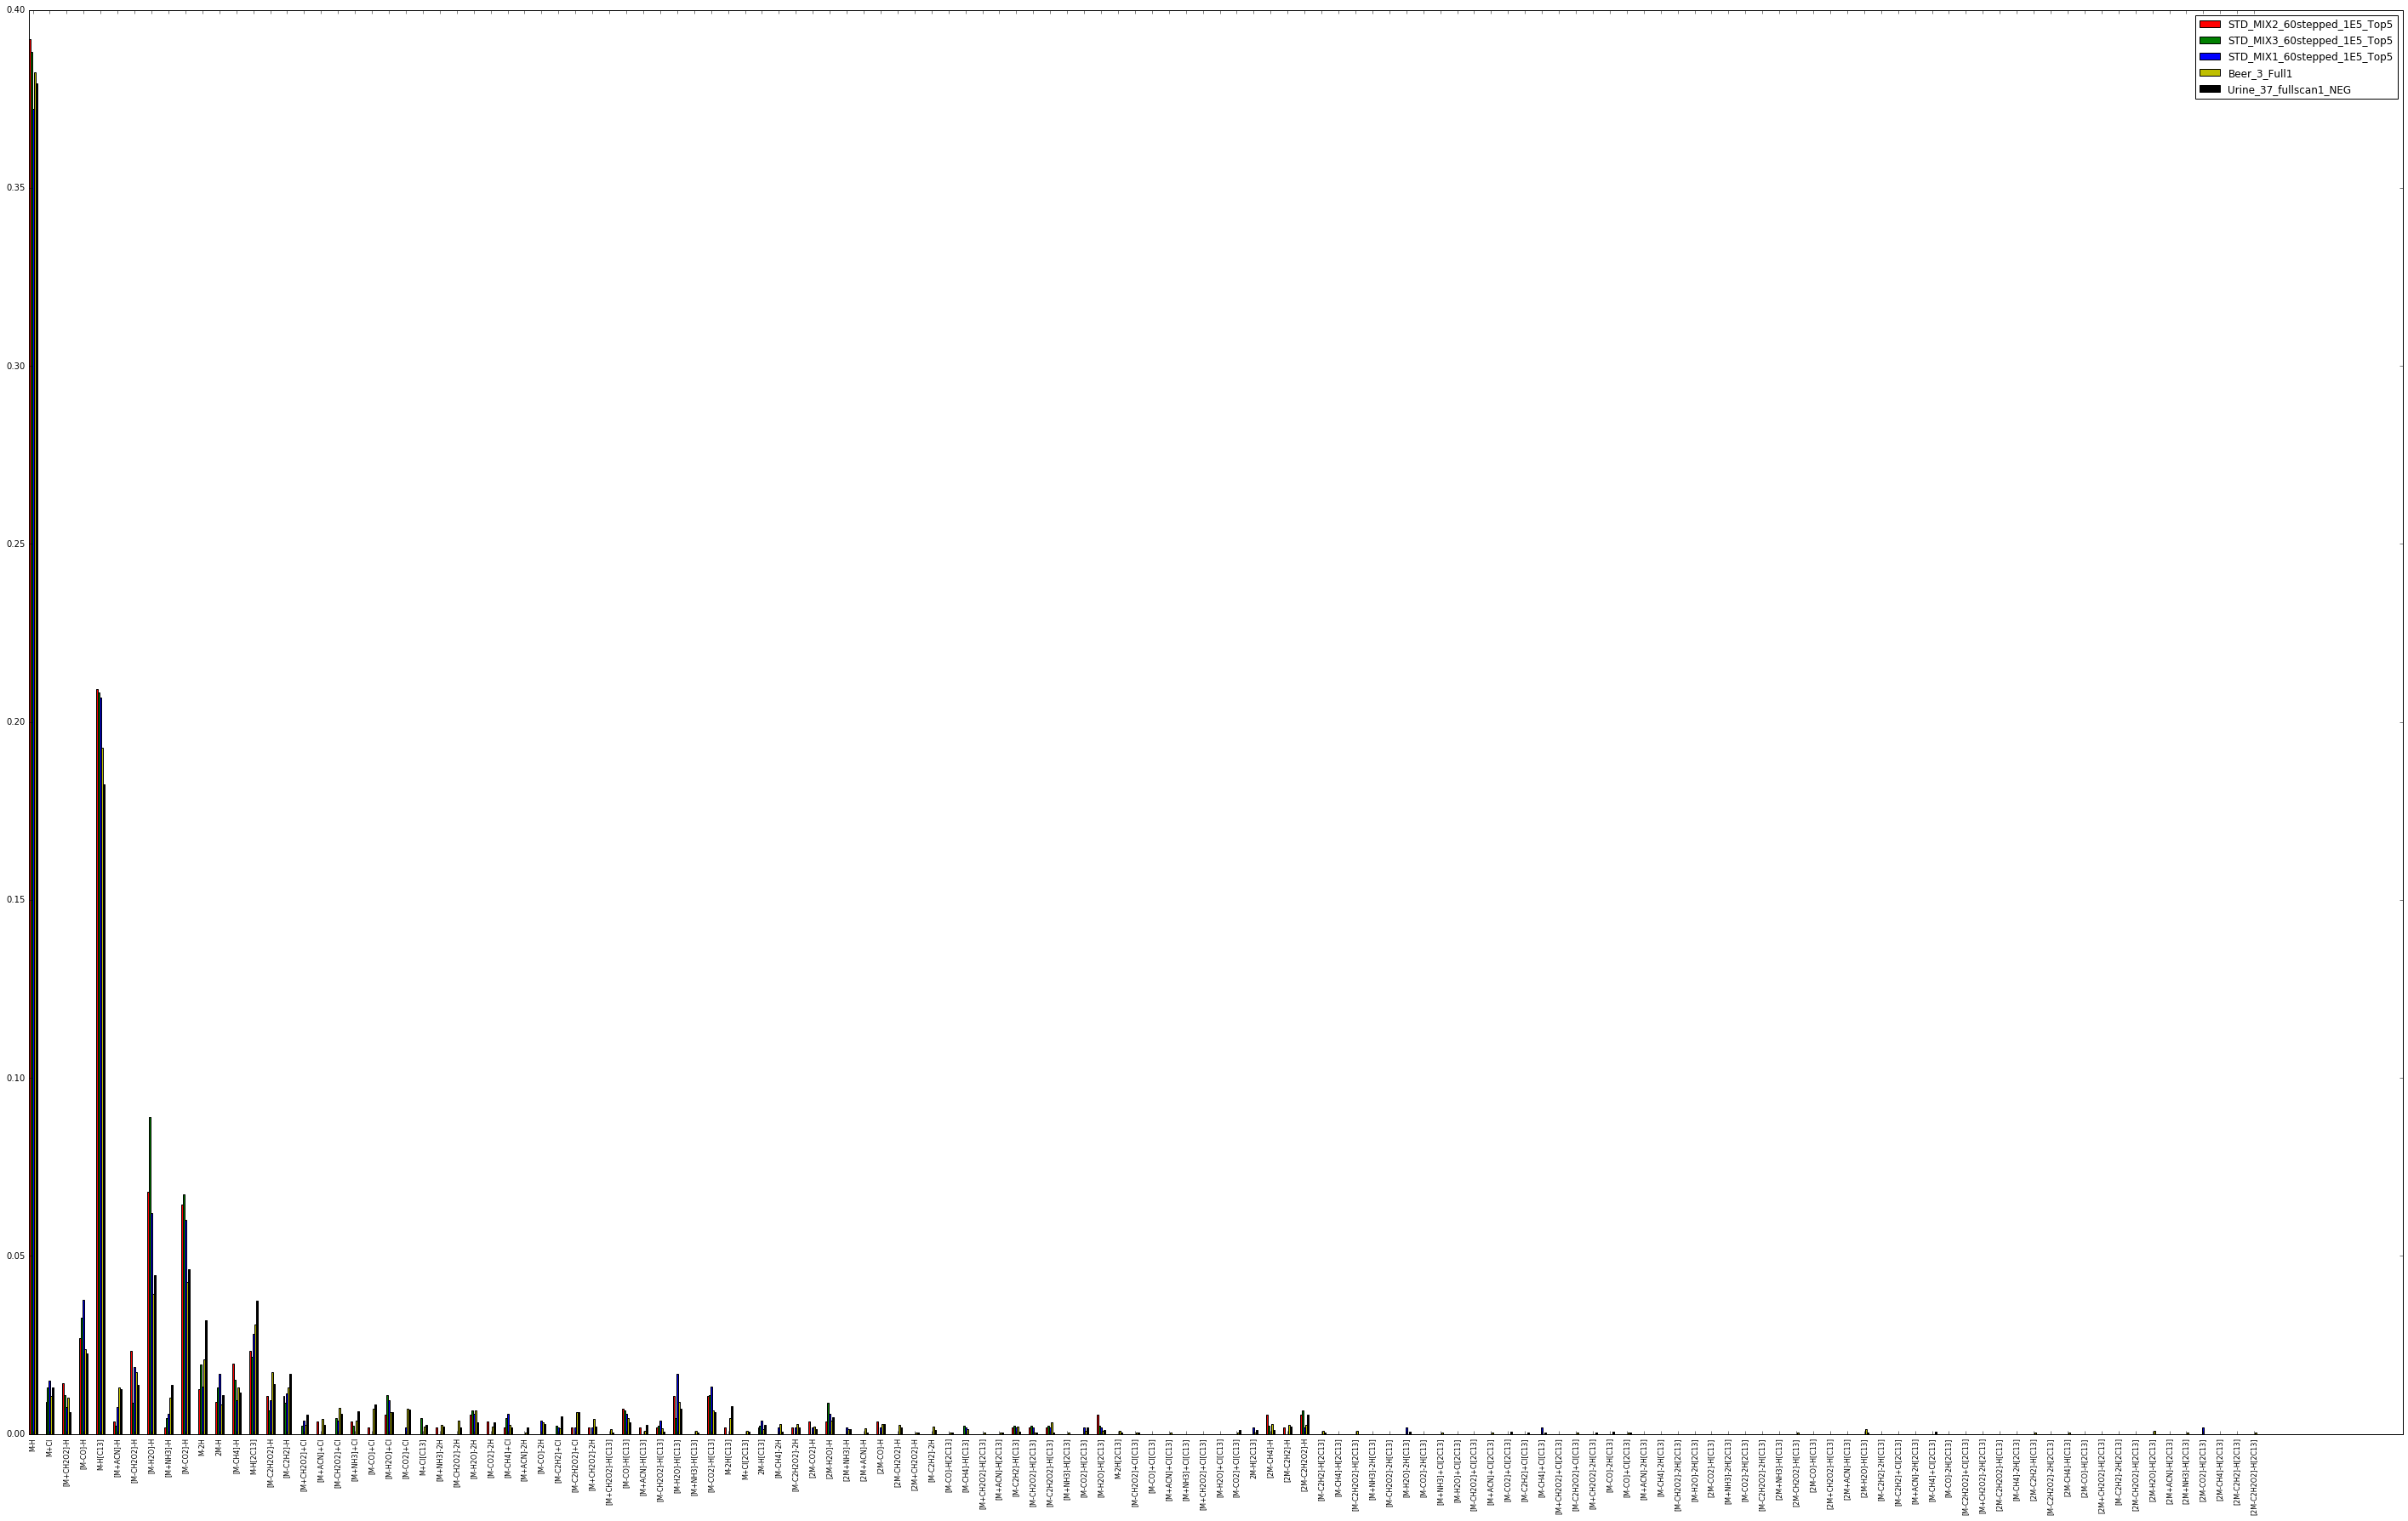

In [16]:
plt.figure(figsize=(50,30))
plt.size((10,10))
N = len(all_trans)
posn = range(N)
nfiles = len(all_files)
width = 0.1
cols = ['r','g','b','y','k','m']
rects = []
for i,filename in enumerate(all_files):
    rects.append(plt.bar([p+width*i for p in posn],trans_perc[filename],width=width,color=cols[i]))
plt.legend(rects,all_files)
plt.xticks([p+width*nfiles/2 for p in posn],all_trans,rotation=90,fontsize=8)
plt.savefig('standard_output/neg/trans_bars.png',dpi=200)